# SVM

## Tasks

### Task 1

Import data you need to solve tasks for this lesson. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('processed_train.csv')

In [3]:
data.head() 

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


In [4]:
data.shape

(119952, 79)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119952 entries, 0 to 119951
Data columns (total 79 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   EngineVersion                                      119952 non-null  float64
 1   AppVersion                                         119952 non-null  float64
 2   AvSigVersion                                       119952 non-null  float64
 3   RtpStateBitfield                                   119952 non-null  float64
 4   IsSxsPassiveMode                                   119952 non-null  int64  
 5   AVProductStatesIdentifier                          119952 non-null  float64
 6   AVProductsInstalled                                119952 non-null  float64
 7   AVProductsEnabled                                  119952 non-null  float64
 8   HasTpm                                             119952 non-null  int64 

### Task 2

Check target class balance.

In [6]:
print(sum(data['HasDetections'] == 1), '- positive class,')
print(sum(data['HasDetections'] == 0), '- negative class')

20012 - positive class,
99940 - negative class


### Task 3

Split data on train and test samples.

In [7]:
y = data['HasDetections']
X = data.drop('HasDetections', axis=1)

In [8]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=33)

### Task 4

Fit a logistic regression using cross_validation and check `accuracy` metric on both train and test samples.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate


cv = [(X_train.index.to_list(), X_test.index.to_list())]

pipe_lr = Pipeline([
    ('scaler', MinMaxScaler()),
    ('logreg', LogisticRegression())
])

result_lr = cross_validate(pipe_lr, X, y, cv=cv, scoring='accuracy', return_train_score=True)

In [10]:
print(f'Train Accuracy: {result_lr["train_score"][0]:.7f}')

Train Accuracy: 0.8416232


In [11]:
print(f'Test Accuracy: {result_lr["test_score"][0]:.7f}')

Test Accuracy: 0.8427744


### Task 5. 

Fit an SVM model using cross_validation and check `accuracy` metric on both train and test samples.

In [12]:
from sklearn.svm import LinearSVC


pipe_svm = Pipeline([
    ('scaler', MinMaxScaler()),
    ('svm', LinearSVC())
])

result_svm = cross_validate(pipe_svm, X, y, cv=cv, scoring='accuracy', return_train_score=True)

In [13]:
print(f'Train Accuracy: {result_svm["train_score"][0]:.7f}')

Train Accuracy: 0.8400288


In [14]:
print(f'Test Accuracy: {result_svm["test_score"][0]:.7f}')

Test Accuracy: 0.8403985


### Task 6. 

Build a ROC-AUC curve for Log-reg model.

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc

Log-reg AUC: 0.689


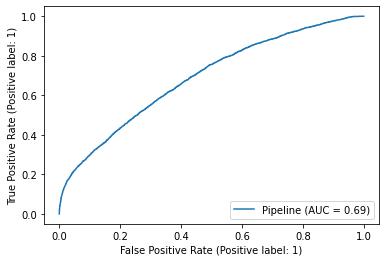

In [16]:
fpr_lr, tpr_lr, thresholds = roc_curve(y_test, pipe_lr.fit(X_train, y_train).predict_proba(X_test)[:, 1])
print(f'Log-reg AUC: {auc(fpr_lr, tpr_lr):.3f}')
RocCurveDisplay.from_estimator(pipe_lr, X_test, y_test);

### Task 7. 

Build a ROC-AUC curve for SVM model.

In [17]:
# first scaling output to probabilities [0, 1] range
def output_scaling(output):
    min_value = min(output)
    max_value = max(output)
    
    probabilities = list()
    
    for value in output:
        if value == min_value:
            probabilities.append(0)
        elif value == max_value:
            probabilities.append(1)
        elif value < 0:
            result = abs(value - min_value) / abs(min_value) * 0.5
            probabilities.append(result)
        else:
            result = (abs(value) / abs(min_value) * 0.5) + 0.5
            probabilities.append(result)
            
    return probabilities


In [18]:
pred_prob = output_scaling(pipe_svm.fit(X_train, y_train).decision_function(X_test))

In [19]:
# Checking that probabilities are in [0, 1] range
print(min(pred_prob))
print(max(pred_prob))

0
1


SVM AUC: 0.688


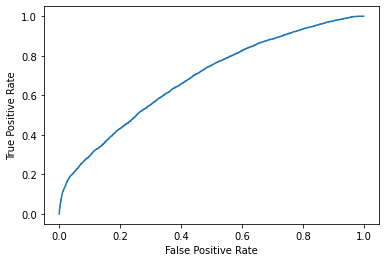

In [20]:
# And now finaly we can build ROC-AUC curve for SVM model
fpr_svm, tpr_svm, thresholds = roc_curve(y_test, pred_prob)
print(f'SVM AUC: {auc(fpr_svm, tpr_svm):.3f}')
RocCurveDisplay(fpr=fpr_svm, tpr=tpr_svm).plot();

### Task 8. 

tbc..